<a href="https://colab.research.google.com/github/monicaneli/Reconhecimento-Facial/blob/main/Reconhecimento_Facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção e Reconhecimento Facial

O presente projeto tem como objetivo desenvolver um sistema automatizado de detecção e reconhecimento de faces, aplicando-o especificamente para identificar os personagens principais da série *The Big Bang Theory*. A solução combina técnicas modernas de visão computacional e aprendizado profundo para realizar duas tarefas principais: detecção de faces em imagens ou vídeos e reconhecimento de identidades específicas.

### 1. Metodologia

**Detecção de faces:**
Para localizar rostos nas imagens, foi utilizada a rede MTCNN (Multi-task Cascaded Convolutional Networks).

**Reconhecimento facial:** FaceNet e um classificador leve (KNN ou SVM).

### 2. Base de Dados

Para o reconhecimento dos personagens, foi construída uma base de 20 imagens por personagem, contendo apenas o rosto, garantindo um treinamento eficiente mesmo com um número reduzido de exemplos. Técnicas de *data augmentation* (giro, flip, ajustes de brilho) foram aplicadas para aumentar virtualmente o conjunto de dados e melhorar a robustez do modelo.


### 3. Tecnologias e Ferramentas

* **Python** com bibliotecas: OpenCV, MTCNN, keras-facenet, scikit-learn.
* **Redes neurais profundas**: MTCNN para detecção e FaceNet para reconhecimento.
* **Classificador leve**: KNN, para mapear embeddings em identidades de personagens.
* **Data augmentation**: aumento de base para robustez.





In [1]:
# Imports e parâmetros
import os
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [27]:
!wget -O tbbt.jpg https://raw.githubusercontent.com/monicaneli/Reconhecimento-Facial/a884633e9a1e34f36e29b74ffbfd6baf2ec1479f/tbbt.jpg
!wget -O Amy_TBBT.jpg https://raw.githubusercontent.com/monicaneli/Reconhecimento-Facial/a884633e9a1e34f36e29b74ffbfd6baf2ec1479f/Amy_TBBT.jpg

--2025-09-16 12:06:01--  https://raw.githubusercontent.com/monicaneli/Reconhecimento-Facial/a884633e9a1e34f36e29b74ffbfd6baf2ec1479f/tbbt.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 270824 (264K) [image/jpeg]
Saving to: ‘tbbt.jpg’

tbbt.jpg            100%[===================>] 264.48K  --.-KB/s    in 0.01s   

2025-09-16 12:06:01 (17.7 MB/s) - ‘tbbt.jpg’ saved [270824/270824]

--2025-09-16 12:06:01--  https://raw.githubusercontent.com/monicaneli/Reconhecimento-Facial/a884633e9a1e34f36e29b74ffbfd6baf2ec1479f/Amy_TBBT.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP req

In [3]:
# Banco de faces para reconhecimento
dataset_path = "/content/TBBT_Faces"

# Dataset Big Bang Theory
!wget -O TBBT.zip "https://github.com/monicaneli/Reconhecimento-Facial/raw/main/TBBT_Faces.zip"
!unzip -q TBBT.zip

--2025-09-16 11:45:36--  https://github.com/monicaneli/Reconhecimento-Facial/raw/main/TBBT_Faces.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/monicaneli/Reconhecimento-Facial/main/TBBT_Faces.zip [following]
--2025-09-16 11:45:36--  https://raw.githubusercontent.com/monicaneli/Reconhecimento-Facial/main/TBBT_Faces.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1004611 (981K) [application/zip]
Saving to: ‘TBBT.zip’

TBBT.zip            100%[===================>] 981.07K  --.-KB/s    in 0.03s   

2025-09-16 11:45:36 (38.0 MB/s) - ‘TBBT.zip’ saved [1004611/1004611]

replace TBBT_Faces/Am

In [4]:
!pip install mtcnn
!pip install keras-facenet
#!pip install lz4
!pip install lz4==4.3.2
#!pip install --upgrade lz4 imageio h5py


  Using cached lz4-4.4.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
Using cached lz4-4.4.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Attempting uninstall: lz4
    Found existing installation: lz4 4.3.2
    Uninstalling lz4-4.3.2:
      Successfully uninstalled lz4-4.3.2


  Using cached lz4-4.3.2-cp312-cp312-linux_x86_64.whl
  Attempting uninstall: lz4
    Found existing installation: lz4 4.4.4
    Uninstalling lz4-4.4.4:
      Successfully uninstalled lz4-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mtcnn 1.0.0 requires lz4>=4.3.3, but you have lz4 4.3.2 which is incompatible.


In [5]:
# Imports
import cv2
import matplotlib.pyplot as plt
from mtcnn import MTCNN
from keras_facenet import FaceNet

## Detecção de faces com MTCNN

Para localizar rostos nas imagens, foi utilizada a rede MTCNN (Multi-task Cascaded Convolutional Networks).

Esta rede é projetada para detectar rostos com alta precisão em diferentes posições, ângulos e condições de iluminação. Ela realiza a detecção em três estágios cascata, refinando progressivamente as localizações de face e estimando pontos-chave faciais (olhos, nariz, boca), permitindo um recorte preciso dos rostos.


In [6]:
# Rede MTCNN (Multi-task Cascaded Convolutional Networks)
from mtcnn import MTCNN
detector = MTCNN()

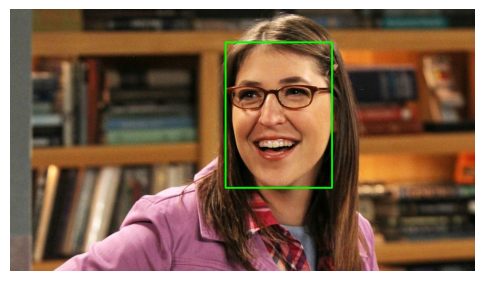

In [7]:
# Teste de detecção de faces
img = cv2.imread("/content/Amy_TBBT.jpg")
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

faces = detector.detect_faces(rgb)

for f in faces:
    x, y, w, h = f['box']
    x, y = max(0,x), max(0,y)  # Garantir que não seja negativo
    face_crop = rgb[y:y+h, x:x+w]

    # Salvar face recortada
    cv2.imwrite("face_detected.jpg", cv2.cvtColor(face_crop, cv2.COLOR_RGB2BGR))

    # Criar uma cópia para desenhar o retângulo
    img_overlay = img.copy()

    # Desenhar retângulo verde ao redor da face
    cv2.rectangle(img_overlay, (x, y), (x+w, y+h), color=(0,255,0), thickness=3)

    # Mostrar imagem com retângulo
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img_overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()



## Reconhcimento Facial

Após a detecção, cada face é processada pela rede FaceNet, que gera embeddings (vetores de características) para cada rosto.

O FaceNet é uma rede profunda pré-treinada que mapeia faces em um espaço de alta dimensão, de forma que rostos da mesma pessoa fiquem próximos entre si, enquanto rostos de pessoas diferentes fiquem distantes.

Esses embeddings são então utilizados para treinar um classificador leve (KNN ou SVM), capaz de reconhecer cada personagem a partir de um pequeno conjunto de imagens de referência.

In [8]:
# Carregar FaceNet
embedder = FaceNet()

# Função para extrair embeddings de uma face
def get_embedding(face_img):
    # Redimensionar para 160x160, que é o padrão do FaceNet
    face = cv2.resize(face_img, (160, 160))
    face = face.astype("float32")
    face = np.expand_dims(face, axis=0)
    return embedder.embeddings(face)[0]


In [22]:
#Comparar face detectada com banco
from numpy.linalg import norm

def recognize_face(img_path, detector, embedder, knn, le):
    img = cv2.imread(img_path)
    if img is None:
        return "Erro: imagem não carregada"

    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = detector.detect_faces(rgb)
    if len(results) == 0:
        return "Nenhuma face detectada"

    x, y, w, h = results[0]['box']
    face = rgb[y:y+h, x:x+w]
    face = cv2.resize(face, (160, 160))

    emb = embedder.embeddings([face])[0]
    pred = knn.predict([emb])[0]
    proba = knn.predict_proba([emb])[0]

    return le.inverse_transform([pred])[0], np.max(proba)


In [10]:
# Pasta de rostos extraídos do dataset
embedder = FaceNet()
X, y = [], []

def augment_image(img):
    """Aplica aumentos simples em uma imagem"""
    aug_imgs = []

    # 1. Flip horizontal
    aug_imgs.append(cv2.flip(img, 1))

    # 2. Rotação pequena
    angle = random.choice([-10, -5, 5, 10])
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    aug_imgs.append(cv2.warpAffine(img, M, (w, h)))

    # 3. Alterar brilho
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[...,1] = hsv[...,1]*random.uniform(0.8,1.2)
    hsv[...,2] = hsv[...,2]*random.uniform(0.7,1.3)
    hsv[hsv > 255] = 255
    aug_imgs.append(cv2.cvtColor(np.array(hsv, dtype=np.uint8), cv2.COLOR_HSV2BGR))

    return aug_imgs

# Preparando o dataset
for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if not os.path.isdir(person_path):
        continue

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (160, 160))

        # Embedding da imagem original
        X.append(embedder.embeddings([img])[0])
        y.append(person)

        # Augmentation → Embeddings das variações
        for aug in augment_image(img):
            aug = cv2.resize(aug, (160, 160))
            X.append(embedder.embeddings([aug])[0])
            y.append(person)

X = np.array(X)
y = np.array(y)

print("Total de embeddings após augmentation:", X.shape, "Labels:", len(y))

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

In [11]:
# Transformar rótulos em inteiros
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Treinar um KNN simples
knn = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
knn.fit(X, y_enc)

print("Classes:", le.classes_)


Classes: ['Amy' 'Bernadete' 'Howard' 'Leonard' 'Penny' 'Raj' 'Sheldon']


In [24]:
# Exemplo: testar com uma imagem da Amy
test_img = '/content/Amy_TBBT.jpg'
label, score = recognize_face(test_img, detector, embedder, knn, le)
print("Reconhecido como:", label, " (confiança:", score, ")")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Reconhecido como: Amy  (confiança: 1.0 )


## Reconhecimeno de múltiplas faces em uma imagem


In [21]:
def recognize_faces_in_frame(frame_path, knn, embedder, le):
    # Carregar frame
    img = cv2.imread(frame_path)
    if img is None:
        return "Erro ao carregar imagem"
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detectar faces
    results = detector.detect_faces(rgb)
    print("Faces detectadas:", len(results))

    for res in results:
        x, y, w, h = res['box']
        face = rgb[y:y+h, x:x+w]
        face = cv2.resize(face, (160, 160))

        # Extrair embedding
        emb = embedder.embeddings([face])[0]

        # Predição
        pred = knn.predict([emb])[0]
        proba = knn.predict_proba([emb])[0]
        label = le.inverse_transform([pred])[0]
        score = np.max(proba)

        # Desenhar bounding box e nome
        cv2.rectangle(rgb, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(rgb, f"{label} ({score:.2f})", (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    # Mostrar imagem final
    plt.figure(figsize=(10,8))
    plt.imshow(rgb)
    plt.axis("off")
    plt.show()

Faces detectadas: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


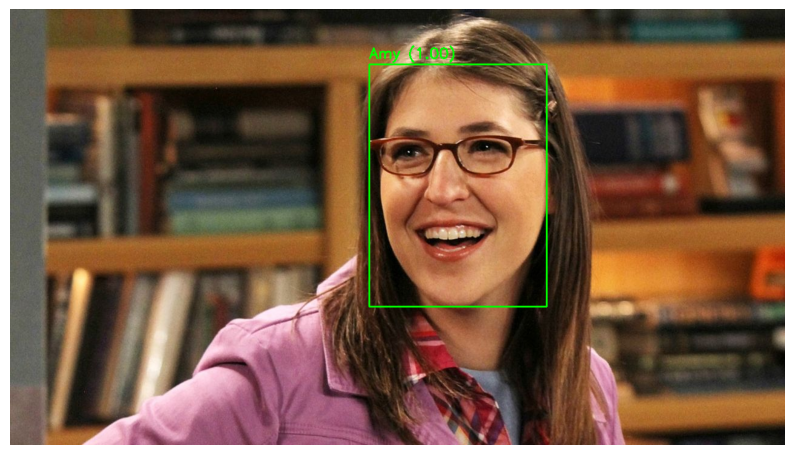

In [28]:
frame_path = "/content/Amy_TBBT.jpg"
recognize_faces_in_frame(frame_path, knn, embedder, le)

Faces detectadas: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


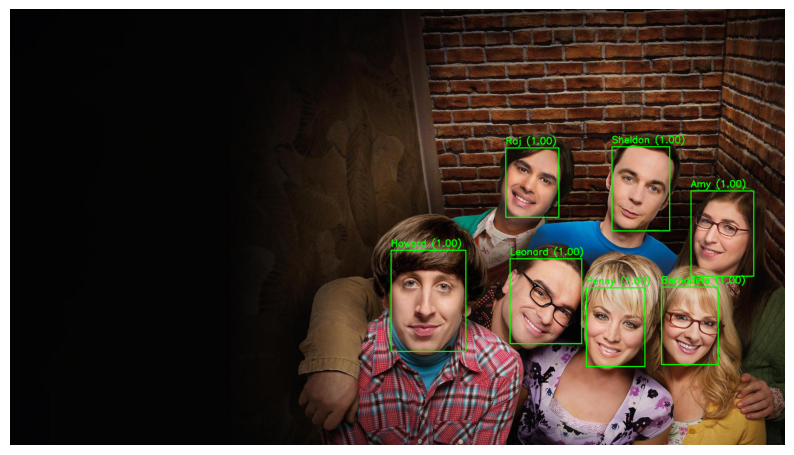

In [29]:
frame_path = "/content/tbbt.jpg"  # vários personagens
recognize_faces_in_frame(frame_path, knn, embedder, le)

## Conclusão

O sistema proposto combina detecção de faces de alta precisão com reconhecimento baseado em embeddings, permitindo identificar os personagens de *The Big Bang Theory* de forma automática e eficiente.

A escolha de MTCNN e FaceNet garante robustez frente a variações de pose, expressão e iluminação, oferecendo uma solução prática para aplicações de reconhecimento facial em séries, vídeos ou imagens estáticas.


## Referências

[1] YOLOv4 Object Detection on Webcam In Google Colab por [Jack Wotherspoon](https://github.com/jackwotherspoon)

[2] Bootcamp BairesDev - Machine Learning Training pela DIO

[3] Imagem Amy disponível em [aventurasnahistoria](https://aventurasnahistoria.com.br/wp-content/uploads/curiosidades/amy_fowler_mayim_bialik.jpg)